In [101]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np

df = pd.read_csv('hpv_prevalence.csv')
# Create 10 year age groups (30-39,40-49,50-59,60-70) coded (0,1,2,3) accordingly 
df['age_group'] = np.floor((df.age - 30)/10)
df['age_group'] = np.where(df.age_group < 3, df.age_group, 3) # joining 70 year-olds with 60-70 group

# Convert age group to category
df['age_group'] = df['age_group'].astype('category')

# Encode categorical variable 'age_group' as integers for indexing
df['age_group'] = df['age_group'].cat.codes
n_age_groups = df['age_group'].nunique()

# Rescaling longest hormonal contraceptives usage period 
df['hc_longest_period_scaled'] = (
    (df['hc_longest_period'] - df['hc_longest_period'].min()) /
    (df['hc_longest_period'].max() - df['hc_longest_period'].min())
)

# Rescaling nr_of_sex_partners 
df['nr_of_sex_partners_scaled'] = (
    (df['nr_of_sex_partners'] - df['nr_of_sex_partners'].min()) /
    (df['nr_of_sex_partners'].max() - df['nr_of_sex_partners'].min())
)

In [103]:
df=df.drop(columns=['Unnamed: 0'])
df.head()

,age,first_sex,nr_of_sex_partners,smoking,hormonal_contrcptvs,hc_longest_period,hrhpv_prevalence,age_group,hc_longest_period_scaled,nr_of_sex_partners_scaled
0,45.0,20.0,6,0,0,0.0,0,1,0.000000,0.384615
1,68.0,19.0,2,1,1,12.0,0,3,0.352941,0.076923
2,59.0,21.0,1,1,0,0.0,0,2,0.000000,0.000000
3,54.0,22.0,1,0,0,0.0,0,2,0.000000,0.000000
4,36.0,19.0,3,0,1,10.0,0,0,0.294118,0.153846


In [105]:
# Let's model
# Kitchen sink method
with pm.Model() as model:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta_smoke = pm.Normal("beta_smoke", mu=0, sigma=1)
    beta_contraceptives = pm.Normal("beta_contraceptives", mu=0, sigma=1)
    beta_nr_sex_partners = pm.Normal("beta_nr_sex_partners", mu=0, sigma=1)
    beta_hc_period = pm.Normal("beta_hc_period", mu=0, sigma=1)
    beta_agegroup = pm.Normal("beta_agegroup", mu=0, sigma=1, shape=n_age_groups)

    # Logistic regression
    logit_p = (
        intercept 
        + beta_smoke * df.smoking 
        + beta_contraceptives * df.hormonal_contrcptvs 
        + beta_nr_sex_partners * df.nr_of_sex_partners_scaled
        + beta_hc_period * df.hc_longest_period_scaled
        + beta_agegroup[df.age_group.values]
    )
    # Likelihood
    y_obs = pm.Bernoulli("y_obs", logit_p=logit_p, observed=df.hrhpv_prevalence)

    # Sampling
    idata = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)
    
# Summary
az.summary(idata, round_to=2) 

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.18        15           232.77 draws/s   0:00:12   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.16        31           230.05 draws/s   0:00:13   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.21        15           223.34 draws/s   0:00:13   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.21        31           182.13 draws/s   0:00:16   0:00:00

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-1.82,0.48,-2.65,-0.85,0.01,0.01,2990.31,3576.55,1.0
beta_smoke,0.38,0.26,-0.10,0.86,0.00,0.00,5441.01,5041.66,1.0
beta_contraceptives,-0.52,0.28,-1.03,0.01,0.00,0.00,6219.43,5274.93,1.0
beta_nr_sex_partners,0.25,0.53,-0.77,1.21,0.01,0.01,5870.79,5350.67,1.0
beta_hc_period,2.05,0.54,1.02,3.02,0.01,0.01,6434.56,5686.98,1.0
beta_agegroup[0],-0.18,0.50,-1.13,0.72,0.01,0.01,3378.02,4231.83,1.0
beta_agegroup[1],-0.67,0.49,-1.61,0.20,0.01,0.01,3181.68,3714.58,1.0
beta_agegroup[2],-0.37,0.47,-1.26,0.49,0.01,0.01,3033.76,3689.23,1.0
beta_agegroup[3],-0.57,0.49,-1.55,0.28,0.01,0.01,3227.03,4200.61,1.0


We can also add some plots to visualise, in my notebook somehow they did not show the plots.
Some plots similar in our lectures:

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_smoke           0.376  0.259  -0.105    0.863      0.004    0.003   
beta_contraceptives -0.520  0.276  -1.027    0.012      0.004    0.003   
beta_hc_period       2.050  0.538   1.021    3.025      0.007    0.006   
beta_agegroup[0]    -0.184  0.496  -1.133    0.724      0.009    0.006   
beta_agegroup[1]    -0.665  0.489  -1.608    0.195      0.009    0.006   
beta_agegroup[2]    -0.370  0.474  -1.264    0.490      0.009    0.006   
beta_agegroup[3]    -0.572  0.490  -1.547    0.276      0.009    0.006   

                     ess_bulk  ess_tail  r_hat  
beta_smoke             5441.0    5042.0    1.0  
beta_contraceptives    6219.0    5275.0    1.0  
beta_hc_period         6435.0    5687.0    1.0  
beta_agegroup[0]       3378.0    4232.0    1.0  
beta_agegroup[1]       3182.0    3715.0    1.0  
beta_agegroup[2]       3034.0    3689.0    1.0  
beta_agegroup[3]       3227.0    4201.0    1.0  


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'beta_smoke'}>,
        <Axes: title={'center': 'beta_smoke'}>],
       [<Axes: title={'center': 'beta_contraceptives'}>,
        <Axes: title={'center': 'beta_contraceptives'}>],
       [<Axes: title={'center': 'beta_nr_sex_partners'}>,
        <Axes: title={'center': 'beta_nr_sex_partners'}>],
       [<Axes: title={'center': 'beta_hc_period'}>,
        <Axes: title={'center': 'beta_hc_period'}>],
       [<Axes: title={'center': 'beta_agegroup'}>,
        <Axes: title={'center': 'beta_agegroup'}>]], dtype=object)

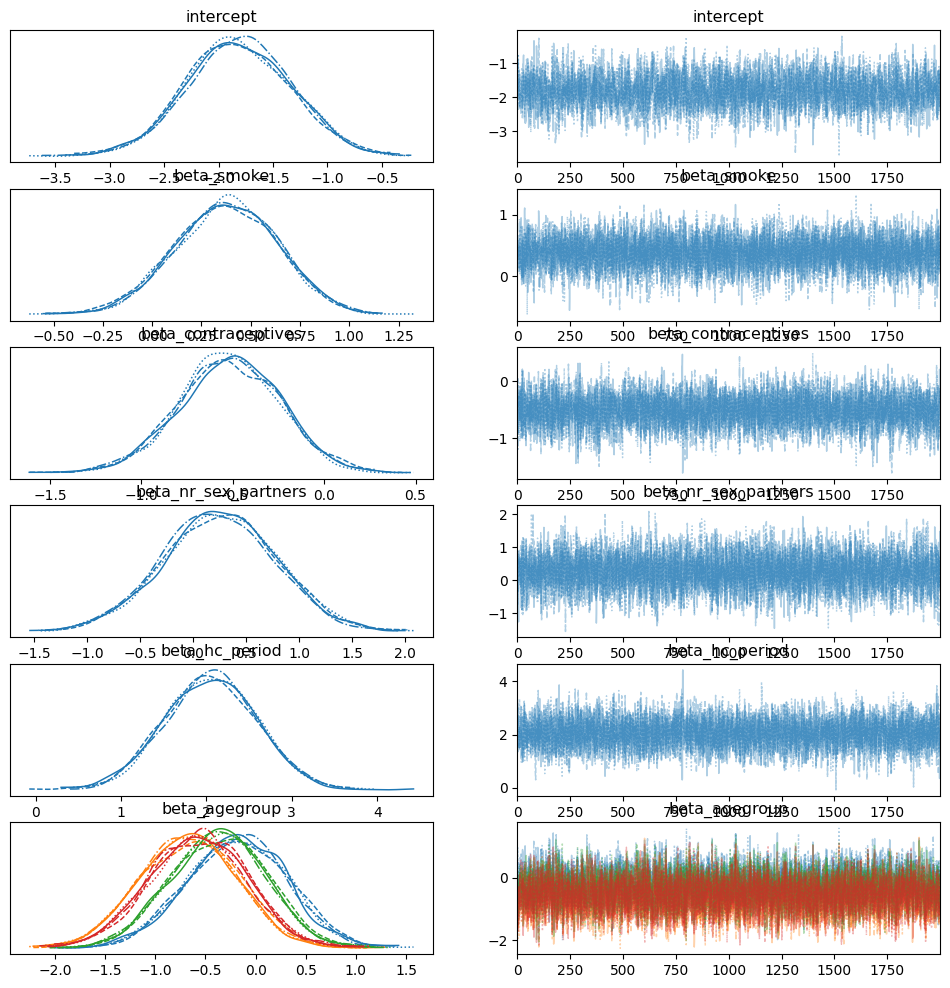

In [107]:
print(az.summary(idata,var_names=['beta_smoke','beta_contraceptives','beta_hc_period', 'beta_agegroup']))
az.plot_trace(idata)
#plt.show()

In [111]:
# Let's model
# Kitchen sink method
with pm.Model() as model:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta_smoke = pm.Normal("beta_smoke", mu=0, sigma=1)
    beta_contraceptives = pm.Normal("beta_contraceptives", mu=0, sigma=1)
    beta_nr_sex_partners = pm.Normal("beta_nr_sex_partners", mu=0, sigma=1)
    #beta_hc_period = pm.Normal("beta_hc_period", mu=0, sigma=1)
    beta_agegroup = pm.Normal("beta_agegroup", mu=0, sigma=1, shape=n_age_groups)

    # Logistic regression
    logit_p = (
        intercept 
        + beta_smoke * df.smoking 
        + beta_contraceptives * df.hormonal_contrcptvs 
        + beta_nr_sex_partners * df.nr_of_sex_partners_scaled
        + beta_agegroup[df.age_group.values]
    )
    # Likelihood
    y_obs = pm.Bernoulli("y_obs", logit_p=logit_p, observed=df.hrhpv_prevalence)

    # Sampling
    idata = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)
    
# Summary
az.summary(idata, round_to=2) 

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.26        23           254.71 draws/s   0:00:11   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.16        31           261.13 draws/s   0:00:11   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.19        15           278.17 draws/s   0:00:10   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.13        15           202.24 draws/s   0:00:14   0:00:00

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-1.86,0.47,-2.73,-0.95,0.01,0.01,2769.12,3831.23,1.0
beta_smoke,0.39,0.25,-0.07,0.88,0.00,0.00,6349.42,4832.79,1.0
beta_contraceptives,0.04,0.23,-0.36,0.50,0.00,0.00,6405.85,5188.37,1.0
beta_nr_sex_partners,0.48,0.51,-0.50,1.42,0.01,0.01,5738.26,5179.04,1.0
beta_agegroup[0],-0.28,0.50,-1.18,0.67,0.01,0.01,2824.81,3924.01,1.0
beta_agegroup[1],-0.51,0.48,-1.44,0.34,0.01,0.01,2753.59,3840.04,1.0
beta_agegroup[2],-0.39,0.47,-1.28,0.49,0.01,0.01,2878.20,3807.76,1.0
beta_agegroup[3],-0.61,0.48,-1.52,0.33,0.01,0.01,2914.97,4262.15,1.0


In [ ]:
print(az.summary(idata,var_names=['beta_smoke','beta_contraceptives','beta_hc_period', 'beta_agegroup']))
az.plot_trace(idata)
#plt.show()